In [1]:
import pandas as pd
from mxnet import gluon, autograd, init, nd
from mxnet.gluon import nn
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/dataCLean.csv', index_col = 0)

In [3]:
df['Dateime'] = pd.to_datetime(df.Datetime)

In [4]:
df.columns

Index(['SerialNumber', 'City', 'Name', 'longitude', 'latitude', 'FirstOnline',
       'Datetime', 'PM2.5', 'USAQI', 'CO2', 'Temperature', 'RelativeHumidity',
       'Outdoor PM2.5', 'OutdoorUSAQI', 'weekday', 'weekdayName', 'hour',
       'month', 'year', 'dayofmonth', 'tmpc', 'relh', 'drct', 'sped', 'vsby',
       'Dateime'],
      dtype='object')

In [5]:
drop_columns = ['Name', 'longitude', 'latitude', 'FirstOnline', 'Outdoor PM2.5', 'OutdoorUSAQI']
dfs = df.sort_values('Datetime')
dfs.reset_index(inplace = True, drop = True)
dfn = dfs.drop(drop_columns, axis = 1)

dfn.head()

,SerialNumber,City,Datetime,PM2.5,USAQI,CO2,Temperature,RelativeHumidity,weekday,weekdayName,hour,month,year,dayofmonth,tmpc,relh,drct,sped,vsby,Dateime
0,4ypxth4,Karachi,2016-10-06 14:00:00,24.0,76,502.0,30.0,78.0,3,Thursday,14,10,2016,6,NaN,NaN,NaN,NaN,NaN,2016-10-06 14:00:00
1,4ypxth4,Karachi,2016-10-06 14:00:00,24.0,76,502.0,30.0,78.0,3,Thursday,14,10,2016,6,NaN,NaN,NaN,NaN,NaN,2016-10-06 14:00:00
2,4ypxth4,Karachi,2016-10-06 15:00:00,22.0,72,420.0,30.0,76.0,3,Thursday,15,10,2016,6,NaN,NaN,NaN,NaN,NaN,2016-10-06 15:00:00
3,4ypxth4,Karachi,2016-10-06 15:00:00,22.0,72,420.0,30.0,76.0,3,Thursday,15,10,2016,6,NaN,NaN,NaN,NaN,NaN,2016-10-06 15:00:00
4,4ypxth4,Karachi,2016-10-06 17:00:00,21.0,70,416.0,30.0,76.0,3,Thursday,17,10,2016,6,NaN,NaN,NaN,NaN,NaN,2016-10-06 17:00:00


In [6]:
s = 0
print(dfn.SerialNumber.unique()[s])
dfone = dfn[dfn.SerialNumber == dfn.SerialNumber.unique()[s]]
dfone = dfone.drop('SerialNumber', axis = 1)
dfone = dfone.groupby('Datetime').mean()
dfone = dfone.reset_index()
dfone['Datetime'] = pd.to_datetime(dfone.Datetime)

datediff = dfone.Datetime.diff()
print(datediff.head(50))
datediffone = datediff.value_counts().index[0]

firstind = datediff[datediff != datediffone].index
print(firstind)

print(dfone.shape)
print(dfone.isna().sum().sum())

4ypxth4
0         NaT
1    01:00:00
2    02:00:00
3    01:00:00
4    01:00:00
5    01:00:00
6    01:00:00
7    01:00:00
8    01:00:00
9    01:00:00
10   01:00:00
11   01:00:00
12   01:00:00
13   01:00:00
14   01:00:00
15   01:00:00
16   01:00:00
17   01:00:00
18   01:00:00
19   01:00:00
20   01:00:00
21   01:00:00
22   01:00:00
23   01:00:00
24   01:00:00
25   01:00:00
26   01:00:00
27   01:00:00
28   01:00:00
29   01:00:00
30   01:00:00
31   01:00:00
32   01:00:00
33   01:00:00
34   01:00:00
35   01:00:00
36   01:00:00
37   01:00:00
38   01:00:00
39   01:00:00
40   01:00:00
41   01:00:00
42   01:00:00
43   01:00:00
44   01:00:00
45   01:00:00
46   01:00:00
47   01:00:00
48   01:00:00
49   01:00:00
Name: Datetime, dtype: timedelta64[ns]
Int64Index([    0,     2,   142,   253,   276,   420,   736,   894,   997,
             1099,  1158,  1195,  1233,  1280,  1313,  1349,  1357,  1404,
             1513,  1548,  1647,  1675,  1709,  1732,  1897,  2134,  2165,
             2181,  2233,  2

In [7]:
one_hot = pd.get_dummies(dfone.weekdayName)
dfone = dfone.drop(['Datetime', 'weekday', 'weekdayName'], axis = 1)
dfone = (dfone - dfone.mean())/dfone.std()
dfone = dfone.join(one_hot)
dfone.head()

AttributeError: 'DataFrame' object has no attribute 'weekdayName'

In [9]:
net = nn.Sequential()

In [10]:
net.add(nn.Dense(120,activation='sigmoid'),
        nn.Dense(40, activation='sigmoid'),
        nn.Dense(1)
)

net

Sequential(
  (0): Dense(None -> 120, Activation(sigmoid))
  (1): Dense(None -> 40, Activation(sigmoid))
  (2): Dense(None -> 1, linear)
)

In [12]:
batch_size=256

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
#    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # The “take” function will then return the corresponding element based
        # on the indices

In [14]:
def train_test_split(df, l, ratio):
  num = int(len(df) * ratio)
  indices = list(df.index)
#  random.shuffle(indices)
  train = indices[:num]
  test = indices[num:]
  return df.iloc[train], df.iloc[test], l.iloc[train], l.iloc[test]

In [15]:
def eva(net, X, y, l, plot = False):
  y_hat = net(X)
  if plot:
    for i in range(0, min(len(y), 150), 50):
      plt.plot(y[i : i+50].asnumpy())
      plt.plot(y_hat[i : i+50].asnumpy())
      plt.show()
  return l(y_hat, y).mean().asscalar()


epoch number  0
traingin data loss	 0.04871209
testing data loss	 1.055006
epoch number  1
traingin data loss	 0.041121785
testing data loss	 0.938673
epoch number  2
traingin data loss	 0.033205155
testing data loss	 0.8159403
epoch number  3
traingin data loss	 0.026062643
testing data loss	 0.69025666
epoch number  4
traingin data loss	 0.021264665
testing data loss	 0.5699406
epoch number  5
traingin data loss	 0.01887657
testing data loss	 0.46629614
epoch number  6
traingin data loss	 0.02022607
testing data loss	 0.39280468
epoch number  7
traingin data loss	 0.024636723
testing data loss	 0.34538865
epoch number  8
traingin data loss	 0.023835855
testing data loss	 0.30295148
epoch number  9
traingin data loss	 0.019124715
testing data loss	 0.2671375
epoch number  10
traingin data loss	 0.016268939
testing data loss	 0.23752692
epoch number  11
traingin data loss	 0.01437572
testing data loss	 0.21285404
epoch number  12
traingin data loss	 0.013107422
testing data loss	 0.192

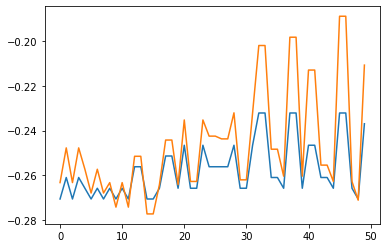

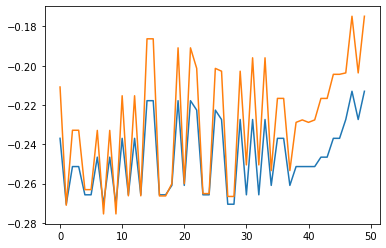

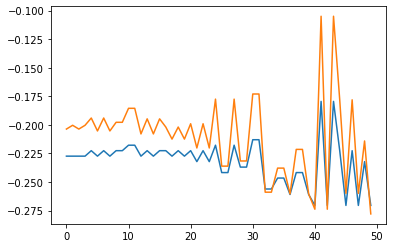

traingin data loss	 0.0022589054


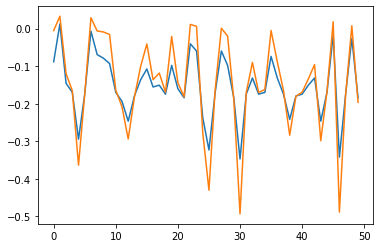

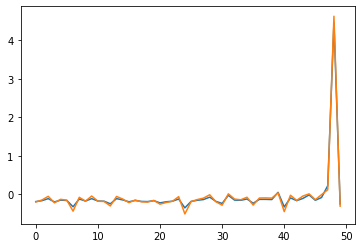

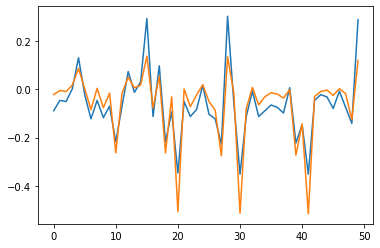

testing data loss	 0.01602595


In [16]:
lr = 0.1
num_epochs = 50

features = dfk.drop('PM2.5', axis = 1)
labels = dfk['PM2.5']

random.seed(6)

tra_f, tes_f, tra_l, tes_l = train_test_split(features, labels, 0.6)
tra_f = nd.array(tra_f.to_numpy())
tes_f = nd.array(tes_f.to_numpy())
tra_l = nd.array(tra_l.to_numpy())
tes_l = nd.array(tes_l.to_numpy())


net.initialize(force_reinit=True,  init=init.Xavier())
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size , tra_f, tra_l):
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        trainer.step(X.shape[0])
    print('epoch number ', epoch)
    print("traingin data loss\t", eva(net, tra_f, tra_l, loss, epoch == num_epochs - 1) )
    print("testing data loss\t", eva(net, tes_f, tes_l, loss, epoch == num_epochs - 1) )    